# Training experiments

This notebook aims at running some training experiments for our ML use case: predicting the `Purchase` target label from the features available and chosen during the data exploration.

More specifically, we will run:
- a linear regression as a baseline
- a random forest
- an XGBoost
- TODO: additional models

Then we will try to append an additional preprocessing step: a dimensionality reduction via a matrix factorisation.
<br>_Reason is that such a dimensionality reduction step may help in case of very high cardinalities of categorical features._

__Important note about evaluating the model performances__:
<br>Even if RMSE is used as the main metric to optimise for the models, we do think that calculating more metrics gives a broader picture.
<br>We will focus our reasoning on two main metrics:
- RMSE: advantage is to be expressed in the original unit (great advantage for business purposes) while caveat is to know the entire target label distribution to fully locate the error
- R2: advantage is to lie on a standard scale (like `[0, 1]` or `[-∞, 1]` depending on the implementation - meaning that we do not need to reason with the original target distribution), while caveat is that such metric is dataset dependant (caveat that we overcome by using exactly the same dataset splits).
<br>In all our ML experiments, we will plot the distributions of the model predictions vs. the groundtruth labels in addition to the regular evaluation metrics (RMSE, R2, etc.)
<br>Please take into consideration that the goodness of fit of such distributions is ___NOT___ a sufficient condition to have a perfect model, but remains a __necessary condition__.

## Preprocessing

The following features will be considered as categorical:
- `User_ID`
- `Product_ID`
- `Gender`
- `Age`
- `Occupation`
- `City_Category`
- `Marital_Status`
- `Product_Category_1`
- `Product_Category_2`
- `Product_Category_3`

Such categorical features will have any missing values (originally blank as `null`) filled with the string `missing` via the Sklearn `SimpleImputer`.
<br>They will then be encoded by Sklearn `OneHotEncoder` set to ignore unknown values from training during inference.

We will consider only one feature as numeric: `Stay_In_Current_City_Years`.
<br>Such feature will first be cleaned with a custom-made routine imported via Sklearn `FunctionTransformer`.
<br>Then Sklearn `SimpleImputer` will be applied for any missing value filled in with `-1`.
<br>Caution can be taken that we did not try to standardize the numeric features since we have only one numeric feature with a scale `[-1, 4]`.
<br>Furthermore, from the instructions, we foresee to use ensembles of decision trees, which are non sensitive to different feature scales.

Sklearn `ColumnTransformer` will be used to aggregate both numeric & categorical features into a model of interest - from a linear regression to an XGBoost.

TODO:
Let's use `Product_Category_2` & `Product_Category_3` as they are, without additional imputation of missing values.

In [1]:
%load_ext autoreload
%autoreload 2

## Baseline model

Training...
   Training time: 24.93 s


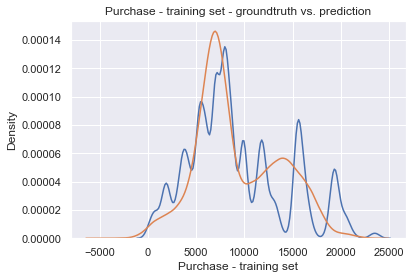

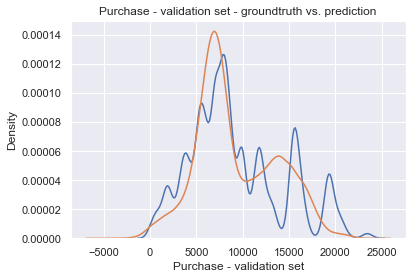

2022/05/23 02:14:19 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
Registered model 'lin_reg_imputed' already exists. Creating a new version of this model...
2022/05/23 02:14:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lin_reg_imputed, version 3
Created version '3' of model 'lin_reg_imputed'.


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from modeling.models import get_imputed_preprocessor
from pprint import pprint
from modeling.models import train_eval
from data.data import import_data

# Get training data
X, y = import_data(file="train")

lin_reg_model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("regressor", LinearRegression())
    ]),
    model_name="lin_reg_imputed",
    plot_preds=True
)

In [5]:
pprint(valid_perf)

{'MAE': 1852.2647430755453,
 'MedAE': 1398.1266272745088,
 'R2': 0.7528227843300574,
 'RMSE': 2500.413028813544,
 'explained_variance': 0.7528289185259636,
 'max_error': 16314.210923917122,
 'r2': 0.7528544003773947}


The choice of a train/test split of 70% / 30% is made to fit at best the real conditions: this is the same ratio of training vs. testing examples for which we will have to serve the final model.

Actually using a Linear Regression gives a very good result with an R2 of __0.75__ during the test.
<br>In terms of RMSE, we are at __2500__ for the test performance.

Such baseline may be difficult to beat indeed.

As for the plots, the linear model gives smoother prediction than the groundtruth.
<br>Currently as a sign of underfitting, the model performance can be improved.

#### Comment

Sklearn R2 version (used here) implements the *Nash–Sutcliffe model efficiency coefficient* - denoting a goodness-of-fit indicator that can vary from -∞ to 1.
<br>Having a negative R2 means that the model is worse than a naive one always predicting the mean of the target variable $\bar{y}$.

In the plots, we can see negative values for the `Purchase` variable.
<br>These are just artefacts from the KDE-fitting and they must be discarded.

## Sklearn Random Forest model

Training...
   Training time: 46.24 s


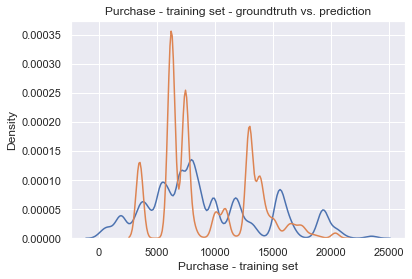

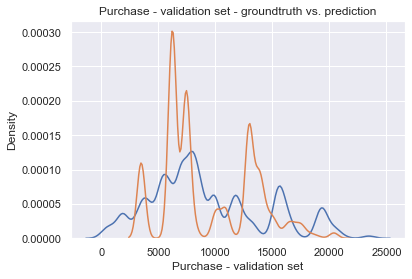

2022/05/23 02:02:42 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
Registered model 'random_forest_imputed' already exists. Creating a new version of this model...
2022/05/23 02:02:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: random_forest_imputed, version 2
Created version '2' of model 'random_forest_imputed'.


{'MAE': 2326.4843768782875,
 'MedAE': 1932.6604391276578,
 'R2': 0.640495551933188,
 'RMSE': 3015.502336989482,
 'explained_variance': 0.6404983985677888,
 'max_error': 19997.30394072184,
 'r2': 0.6404984349123785}


In [6]:
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': 30, 'criterion': 'mse', 'max_depth': 10,
    'random_state': 18, 'max_features': 'auto', 'n_jobs': -1
}

model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("regressor", RandomForestRegressor(**params))
    ]),
    model_params=params,
    model_name="random_forest_imputed",
    plot_preds=True
)

pprint(valid_perf)

Weirdly the Random Forest does not beat the linear regression, with a test performance of __0.64__ in R2 & __3012__ in RMSE.
<br>It might be due to the hyperparameter values that we have set: a few trees (_30_) and still quite shallow for a Random Forest model (_max_depth_ of 10).

The purpose of such experiments is not to reach the best performance but just to reach some early findings.

In the plots, we can see that the Random Forest actually tries to better fit by giving more granular predictions than the linear regression; however its performance fails to be better.

## XGBoost

Training...
   Training time: 20.30 s


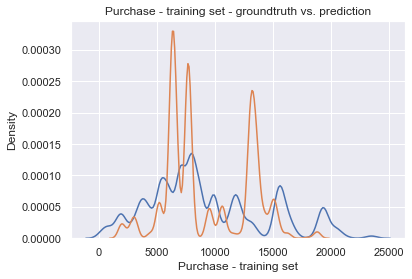

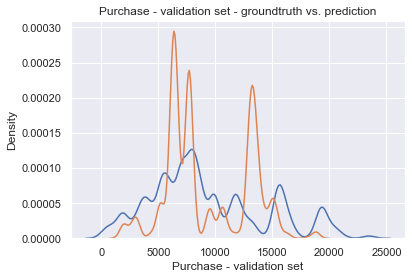

2022/05/23 02:04:02 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
Registered model 'xgb_imputed' already exists. Creating a new version of this model...
2022/05/23 02:04:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgb_imputed, version 2
Created version '2' of model 'xgb_imputed'.


In [7]:
from xgboost import XGBRegressor
from multiprocessing import cpu_count

params = {
    'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0,
    'random_state': 0, 'n_jobs': cpu_count()
}

model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("regressor", XGBRegressor(**params))
    ]),
    model_params=params,
    model_name="xgb_imputed",
    plot_preds=True
)

The same remark formulated for the Random Forest model stands for the XGBoost one.
<br>The XGBoost actually underperforms compared to the linear regression baseline, with a test performance of __0.65__ in R2 & __2991__ in RMSE.

In the plots, we can see that the XGBoost tries to better fit by giving more granular predictions than the linear regression, and even more detailed ones than the Random Forest;  however still its performance fails to be better than the baseline.

## Matrix Factorisation + XGBoost

Training...
   Training time: 348.92 s


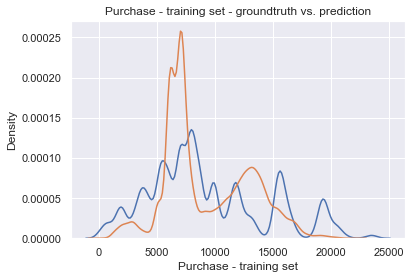

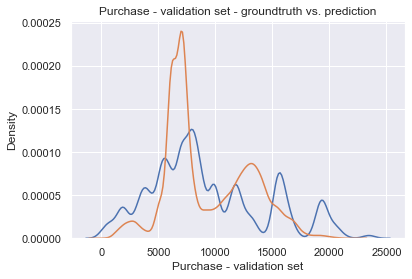

2022/05/23 02:10:51 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
Registered model 'reduced_xgb_imputed' already exists. Creating a new version of this model...
2022/05/23 02:10:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: reduced_xgb_imputed, version 2
Created version '2' of model 'reduced_xgb_imputed'.


In [8]:
from sklearn.decomposition import TruncatedSVD

SVD_params = {
    'n_components': 100, 'random_state': 0
}

XGB_params = {
    'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0,
    'random_state': 0, 'n_jobs': cpu_count()
}

model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("reductor", TruncatedSVD(**SVD_params)),
        ("regressor", XGBRegressor(**XGB_params))
    ]),
    model_params={"svd": SVD_params, "xgb": XGB_params},
    model_name="reduced_xgb_imputed",
    plot_preds=True
)

The dimensionality reduction boosts a little the performances, but not significantly.
<br>The reduced XGBoost does not beat the baseline, with a test performance of __0.65__ in R2 & __2969__ in RMSE.

In terms of plots, we can see that the reduced XGBoost tries to better fit by giving more granular predictions than the linear regression, and less off predictions than the XGBoost alone; however still its performance fails to be better than the baseline.

## General observations

All the results above are very similar with the ones of the initial notebook.
<br>For some models the performances are slightly higher; for those other ones, slightly lower. In any case the differences are not significant.

We may then ask about the relevance of the features `Product_Category_2` & `Product_Category_3` for the modeling task.

To answer this question, let's retrieve the feature importances.

## Feature importances

Let's use a Catboost regressor to extract the feature importances.

Catboost models are user-friendly in the way that they extract a single value for each categorical feature.
<br>On the contrary, models from Sklearn or XGBoost give as many features importances as the number of distinct categories of a variable, which is not convenient.

Training...
0:	learn: 4730.9606920	total: 443ms	remaining: 43.8s
20:	learn: 2930.3915425	total: 3.99s	remaining: 15s
40:	learn: 2769.4506335	total: 7.37s	remaining: 10.6s
60:	learn: 2730.9839032	total: 10.2s	remaining: 6.49s
80:	learn: 2715.5917074	total: 12.5s	remaining: 2.94s
99:	learn: 2704.5311501	total: 14.6s	remaining: 0us
   Training time: 18.26 s


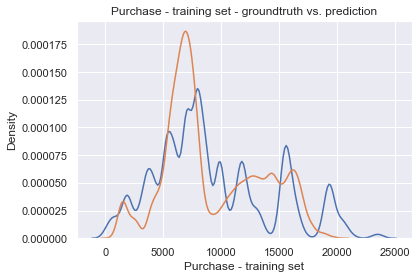

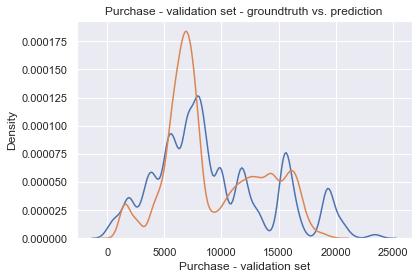

Registered model 'catboost' already exists. Creating a new version of this model...
2022/05/23 02:12:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: catboost, version 2
Created version '2' of model 'catboost'.


{'MAE': 1985.120052850289,
 'MedAE': 1524.50688746606,
 'R2': 0.7204608817418823,
 'RMSE': 2659.064247615926,
 'explained_variance': 0.7204622558398843,
 'max_error': 14739.06594727969,
 'r2': 0.7205220038024011}


In [9]:
from catboost import CatBoostRegressor
from data.data import categorical_features, clean, cast

params = {
    "cat_features": categorical_features,
    "n_estimators": 100, "learning_rate": 0.1, "max_depth": 3, "subsample": 1.0,
    "random_state": 0, "verbose": 20
}

X_catboost = clean(X.copy())
X_catboost = cast(X_catboost)

catboost_model, valid_perf = train_eval(
    X=X_catboost,
    y=y,
    model=CatBoostRegressor(**params),
    model_params=params,
    model_name="catboost",
    plot_preds=True
)

pprint(valid_perf)

In [10]:
from data.data import features
from modeling.models import get_feature_importances

get_feature_importances(catboost_model, features)

,importance,index_position
Product_Category_1,83.151327,8.0
Product_ID,12.661349,1.0
User_ID,3.082565,0.0
Product_Category_2,0.870405,9.0
Product_Category_3,0.104592,10.0
City_Category,0.074029,5.0
Gender,0.029640,2.0
Age,0.026092,3.0
Occupation,0.000000,4.0
Stay_In_Current_City_Years,0.000000,6.0


Even if the contributions of `Product_Category_2` & `Product_Category_3` are not significant, they are not the less informative features.

Then we need to consider using them in the rest of this demonstration.

## Compare models

Compare model runs on the MLFlow UI.  
TODO: extend

So far the Linear regression performs the best.

## Model performance over time

Use EvidentlyAI to track the performance of a trained model.

In [13]:
from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import RegressionPerformanceTab

from evidently.model_profile import Profile
from evidently.model_profile.sections import RegressionPerformanceProfileSection

from data.data import target_label, numeric_features, categorical_features

column_mapping = ColumnMapping(
    target_label,
    "prediction",
    numerical_features=numeric_features,
    categorical_features=categorical_features
)

Create predictions for both train and test datasets. Use the best models so far, which was the linear regression.

In [38]:
ref_data, ref_target = import_data("train")
prod_data, prod_target = import_data("test")
ref_data["prediction"] = lin_reg_model.predict(ref_data)
prod_data["prediction"] = lin_reg_model.predict(prod_data)
ref_data[target_label] = ref_target
prod_data[target_label] = prod_target

Take a look at the model performance dashboard.

In [ ]:
dashboard = Dashboard(tabs=[RegressionPerformanceTab(verbose_level=1)])
dashboard.calculate(ref_data, prod_data, column_mapping=column_mapping)
dashboard.show()